# Bayesian Linear Regression

In this notebook, we consider a more complex example, in which we want to generate samples from the joint distribution of multiple parameters. This is a Bayesian linear regression model, in which the relationship between the matrix $\mathbf{X}$ of model input variables, model parameters $\boldsymbol\beta$ and response vector $\mathbf{y}$ is as follows:
$$ \mathbf{y} = \mathbf{X}\boldsymbol\beta + \boldsymbol\epsilon $$
where $\boldsymbol\epsilon$ is a vector of independent, normally distributed errors.

The above specification gives rise to a multivariate Normal likelihood distribtuion:
$$ \mathbf{y} \sim N( \mathbf{X}\boldsymbol\beta, (\tau \mathbf{I})^{-1}) $$
We supplement this with a multivariate Normal prior distribution for the regression parameters $\boldsymbol\beta$, and Gamma prior distributions for the measurement error precision $\tau{}$ and $\lambda$ the prior precision for $\boldsymbol\beta$:
$$
\begin{align*} 
\beta &\sim N( \mu, (\lambda P_\lambda)^{-1}) \\
\tau &\sim \Gamma( a_\tau, b_\tau) \\
\lambda &\sim \Gamma( a_\lambda, b_\lambda) \\
\end{align*}
$$

In the remainder of this notebook, we generate a synthetic dataset from the model, for a given set of $\boldsymbol\beta$ values, and then use the conjugate sampler functionality within the openmcmc package to sample from the joint posterior distribution of the parameters.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from openmcmc.mcmc import MCMC
from scipy import sparse
from openmcmc.sampler.sampler import NormalNormal, NormalGamma
from openmcmc.model import Model
from openmcmc.distribution.distribution import Gamma
from openmcmc.distribution.location_scale import Normal
from openmcmc.parameter import ScaledMatrix, LinearCombination

## Generating some synthetic data

The below cell generates some synthetic data from the underlying model, using particular values for the parameters $\boldsymbol\beta$ and $\tau$. We assume a single input covariate, with an intercept, and add on Gaussian random noise with a given precision value. 

In [2]:
N = 100

true_beta = np.array([2, 0.5])
x = np.sort(np.random.rand(N))
X = np.stack([np.ones(N), x], 1)
true_tau = 100.0

y = X @ true_beta + norm.rvs(loc=0, scale=np.sqrt(1/true_tau), size=N)

The cell below plots the response as a function of the input variable:

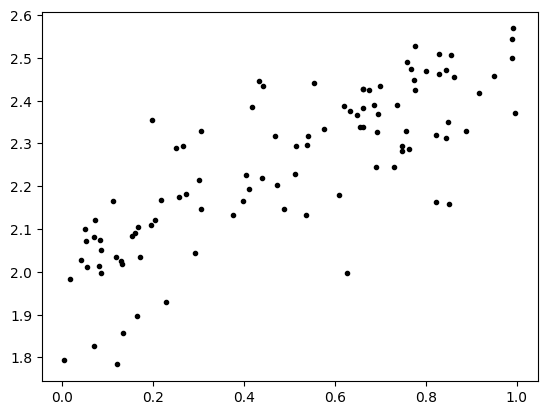

In [3]:
plt.plot(x, y,'k.')
plt.show()

## Setting up the model

We now set up a model using building blocks from the openmcmc toolbox. In this instance, we must use `Parameter` objects to transform the raw input values from the state into predictors that can be used in a multivariate Normal distribution.

The `LinearCombination` parameter is used to define parameter transformations of the form $\mathbf{X}\boldsymbol\beta$, where $\mathbf{X}$ is an $n \times{} p$ matrix and $\boldsymbol\beta{}$ is a $p \times{} 1$ vector. Thus, we use it to define the mean parameter of the response distribution for the regression model.

In [4]:
mean_form = LinearCombination(form={'beta': 'X'})

The `ScaledMatrix` parameter is used to define parameter transformations of the form $\tau{}\mathbf{P}$, where $\tau$ is a scalar parameter, and $\mathbf{P}$ is a square matrix. This is used to define the precision parameters for the response distribution and the parameter prior distribution, where we assume that each response/parameter is independently Normally distributed with the same precision.

In [5]:
tau_predictor = ScaledMatrix(matrix='P_tau', scalar='tau')
lambda_predictor = ScaledMatrix(matrix='P_lambda', scalar='lambda')

Using these parameters, we can then define the full model object in terms of ints individual distributions.

In [6]:
mdl = Model([Normal('y', mean=mean_form, precision=tau_predictor),
             Normal('beta', mean='mu', precision=lambda_predictor),
             Gamma('tau', shape='a_tau', rate='b_tau'),
             Gamma('lambda', shape='a_lambda', rate='b_lambda')], response= {'y': 'mean'})

## Setting up and running the MCMC sampler

Because of the choices of conjugate Normal-Normal and Normal-Gamma pairs of distributions, all of the parameters in this model can be sampled using conjugate conditional samplers. The below cell specifies a conjugate sampler for each of $\boldsymbol\beta$, $\tau$ and $\lambda$. Under this specification, the MCMC sampler will be a Gibbs sampler which iterates through each of these parameters in turn, and samples from its (known) conditional distribution given the current values of the other variables.

In [7]:
sampler = [NormalNormal('beta', mdl),
           NormalGamma('tau', mdl),
           NormalGamma('lambda', mdl)]

The cell below sets up the initial state for the sampler. Note that we set up $\mathbf{P}_{\tau}$ and $\mathbf{P}_{\lambda}$ to be sparse matrices: the sampling methods within the package support the use of sparse matrices, and so using them can substantially speed up inference.

In [8]:
initial_state = {'y': y, 'X': X, 'beta': [0, 0],
                 'P_tau': sparse.csc_matrix(np.eye(N)), 'tau': 1,
                 'P_lambda': sparse.csc_matrix(np.eye(2)), 'mu': [0, 0], 'lambda': 0.01,
                 'a_tau': 1e-3, 'b_tau': 1e-3, 'a_lambda': 1e-3, 'b_lambda': 1e-3}

The MCMC engine can now be set up using the model, samplers and initial state.

In [9]:
M = MCMC(initial_state, sampler, model=mdl, n_burn=1000, n_iter=1000)
M.run_mcmc()
M.store

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1244.80it/s]


{'beta': array([[1.97900425, 1.99602964, 1.97950813, ..., 1.95818562, 2.00012132,
         2.00471731],
        [0.51252331, 0.51497128, 0.56345231, ..., 0.54778293, 0.51560912,
         0.49494672]]),
 'tau': array([[ 86.73426381,  77.41848066,  63.72378612,  91.71589913,
          95.93886833,  73.48229178,  92.4055814 ,  67.63270169,
          93.49734212,  85.93477649,  80.59978445,  79.22199681,
         100.16576752, 103.04752358,  70.36262151, 102.04026826,
          94.99302038,  92.78483829,  98.19723132,  58.84024746,
          77.08928414,  88.06292532,  69.688374  ,  88.43490414,
          91.98902105,  74.62727023,  95.39177009,  84.17512505,
          67.39893396,  79.45729287,  81.93312546,  83.00330543,
          94.98401222,  66.42812495,  95.89922073,  87.58846741,
          79.39561974,  80.53917661, 114.31917027,  69.76501328,
          82.11568032,  77.6658376 ,  60.69766437,  93.14979873,
          77.13947267,  85.68472111,  68.25272671, 102.14174677,
          7

## Plotting the results

The cell below generates trace plots of the MCMC results, with the true parameters used to generate the data shown as red lines.

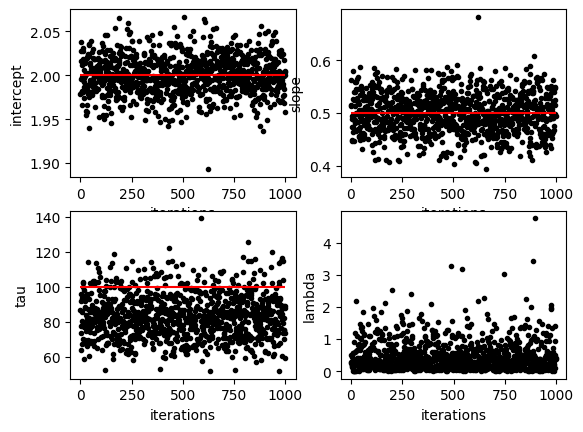

In [10]:
plt.subplot(2, 2, 1)
plt.plot(M.store['beta'][0,:].T,'k.')
plt.hlines(true_beta[0], 0, 1000,'r')
plt.xlabel('iterations')
plt.ylabel('intercept')

plt.subplot(2, 2, 2)
plt.plot(M.store['beta'][1,:].T,'k.')
plt.hlines(true_beta[1], 0, 1000,'r')
plt.xlabel('iterations')
plt.ylabel('slope')

plt.subplot(2, 2, 3)
plt.plot(M.store['tau'].T,'k.')
plt.hlines(true_tau, 0, 1000,'r')
plt.xlabel('iterations')
plt.ylabel('tau')

plt.subplot(2, 2, 4)
plt.plot(M.store['lambda'].T,'k.')
plt.xlabel('iterations')
plt.ylabel('lambda')

plt.show()


The cell below plots the posterior quantiles of the regression line, based on the MCMC samples.

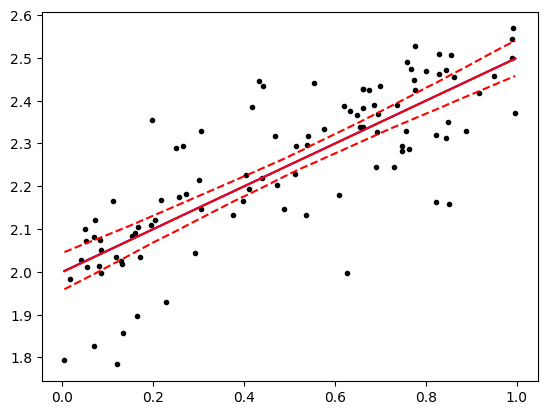

In [11]:
plt.plot(x, y,'k.')

q = np.quantile(M.store['y'], [0.025, 0.5, 0.975], axis=1)
true_line = X @ true_beta

plt.plot(x, true_line,'b-')
plt.plot(x,q[0,:],'r--')
plt.plot(x,q[1,:],'r-')
plt.plot(x,q[2,:],'r--')
plt.show()